In [60]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import parafac
import pandas as pd
from tensorly.decomposition import tucker
import tensorly as tl
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import MeanShift, estimate_bandwidth

In [4]:

# Load hyperspectral dataset from .npy file
hyperspectral_data = np.load('../Assets/030907c-20x-roi2.npy')


In [6]:
X = tl.tensor(hyperspectral_data)

In [7]:
core, factor = tucker(X, rank=[1, 1, 1])

In [8]:
core,factor

(array([[[32360704.]]], dtype=float32),
 [array([[0.02749849],
         [0.02753251],
         [0.02752421],
         ...,
         [0.02908419],
         [0.02900155],
         [0.02896945]], dtype=float32),
  array([[0.02968214],
         [0.02975372],
         [0.02977216],
         ...,
         [0.02618205],
         [0.02614145],
         [0.02614463]], dtype=float32),
  array([[0.1950411 ],
         [0.06135085],
         [0.06179294],
         [0.06231475],
         [0.06443375],
         [0.06581027],
         [0.06723438],
         [0.07370237],
         [0.07662541],
         [0.0853809 ],
         [0.08832186],
         [0.09097613],
         [0.09625118],
         [0.09783242],
         [0.09949101],
         [0.10963048],
         [0.11538767],
         [0.13678253],
         [0.14579427],
         [0.1546257 ],
         [0.17214717],
         [0.17440666],
         [0.17557855],
         [0.17855808],
         [0.18166251],
         [0.19428445],
         [0.19982417],
 

In [9]:
abunMap=factor[0]@factor[1].T
abunMap

array([[0.00081621, 0.00081818, 0.00081869, ..., 0.00071997, 0.00071885,
        0.00071894],
       [0.00081722, 0.00081919, 0.0008197 , ..., 0.00072086, 0.00071974,
        0.00071983],
       [0.00081698, 0.00081895, 0.00081946, ..., 0.00072064, 0.00071952,
        0.00071961],
       ...,
       [0.00086328, 0.00086536, 0.0008659 , ..., 0.00076148, 0.0007603 ,
        0.0007604 ],
       [0.00086083, 0.0008629 , 0.00086344, ..., 0.00075932, 0.00075814,
        0.00075823],
       [0.00085988, 0.00086195, 0.00086248, ..., 0.00075848, 0.0007573 ,
        0.0007574 ]], dtype=float32)

In [10]:
abunMap_normalized = (abunMap - np.min(abunMap)) / (np.max(abunMap) - np.min(abunMap))
abunMap_normalized

array([[0.3465422 , 0.35243782, 0.35395604, ..., 0.05828848, 0.05494487,
        0.05520723],
       [0.34956682, 0.35546955, 0.3569897 , ..., 0.06095639, 0.05760842,
        0.05787131],
       [0.3488287 , 0.3547297 , 0.35624933, ..., 0.06030528, 0.05695836,
        0.05722107],
       ...,
       [0.4875047 , 0.49374023, 0.49534598, ..., 0.18262878, 0.17909236,
        0.17936988],
       [0.48015815, 0.48637575, 0.48797694, ..., 0.17614831, 0.172622  ,
        0.17289883],
       [0.47730458, 0.48351538, 0.48511484, ..., 0.17363136, 0.17010888,
        0.17038538]], dtype=float32)

In [11]:

# Assuming abunMap_normalized is your normalized matrix
e = 0.01  # Length of subintervals

# Define the number of subintervals
num_subintervals = int(1 / e)

# Apply quantization
abunMap_discretized = np.floor(abunMap_normalized / e)

# Ensure that the values are within the range [0, num_subintervals - 1]
abunMap_discretized = np.clip(abunMap_discretized, 0, num_subintervals - 1)

Ed=abunMap_discretized
# Now abunMap_discretized contains the discretized values

In [12]:

# Assuming Ed is your matrix and Su is the set of unique values from Ed in ascending order

# Constructing the set Z
Z = Ed.flatten()

# Constructing the set Su containing unique values from Z in ascending order
Su = np.unique(Z)

# Constructing the matrix F
F = np.zeros_like(Ed, dtype=int)

# Associate values of pixels from Ed with the index of pixel values from Su
for i, value in enumerate(Su):
    F[Ed == value] = i

# F now contains the values where each value corresponds to the index of the pixel value from Su

In [13]:

from scipy.ndimage import uniform_filter

def calculate_histogram(block, num_bins):
    return np.histogram(block, bins=max(num_bins, 1), range=(0, num_bins-1))[0]

def calculate_median_value(values):
    if len(values) == 0:
        return np.nan
    sorted_values = np.sort(values)
    mid_index = len(sorted_values) // 2
    if len(sorted_values) % 2 == 0:
        return (sorted_values[mid_index] + sorted_values[mid_index - 1]) / 2
    else:
        return sorted_values[mid_index]

def find_voronoi_nodes(F, abunMap, n, e, p, x_offset=0, y_offset=0):
    voronoi_nodes = []

    nr = n ** 2  # Number of pixels in the block
    ne = max(int((np.max(F) - np.min(F)) / e), 1)  # Number of bins

    if n == 1:
        return voronoi_nodes

    for i in range(0, F.shape[0], n):
        for j in range(0, F.shape[1], n):
            block = F[i:i+n, j:j+n]

            if block.shape[0] == 1:
                continue  # Ignore blocks with only one pixel

            histogram = calculate_histogram(block, ne)
            max_value = np.max(histogram)

            if max_value >= p * nr / 100:
                # Block is a pure zone
                xg, yg = np.unravel_index(np.argmax(block), block.shape)
                values = block[block == np.argmax(block)]
                voronoi_node_value = calculate_median_value(values)
                if not np.isnan(voronoi_node_value):
                    # Store (a, x, y) tuple
                    x_index, y_index = np.unravel_index(np.argmax(block), block.shape)
                    x_coordinate = i + x_index + x_offset
                    y_coordinate = j + y_index + y_offset
                    abunMap_value = abunMap[x_coordinate, y_coordinate]
                    voronoi_nodes.append((abunMap_value, x_coordinate, y_coordinate))
            else:
                # Split the block into four cells and repeat the process
                if n > 1:
                    voronoi_nodes.extend(find_voronoi_nodes(F[i:i+n//2, j:j+n//2], abunMap, n//2, e, p, x_offset+i, y_offset+j))
                    voronoi_nodes.extend(find_voronoi_nodes(F[i:i+n//2, j+n//2:j+n], abunMap, n//2, e, p, x_offset+i, y_offset+j+n//2))
                    voronoi_nodes.extend(find_voronoi_nodes(F[i+n//2:i+n, j:j+n//2], abunMap, n//2, e, p, x_offset+i+n//2, y_offset+j))
                    voronoi_nodes.extend(find_voronoi_nodes(F[i+n//2:i+n, j+n//2:j+n], abunMap, n//2, e, p, x_offset+i+n//2, y_offset+j+n//2))

    return voronoi_nodes

# Example usage:
# voronoi_nodes = find_voronoi_nodes(F, abunMap, n, e, p)


In [20]:
# Example usage
# Assuming F is your matrix, n is the dimension of square blocks, e is the interval length, p is the threshold value
voronoi_nodes = find_voronoi_nodes(F, abunMap, n=64, e=0.01, p=30)

In [21]:
np.array(voronoi_nodes).shape

(427, 3)

# 3

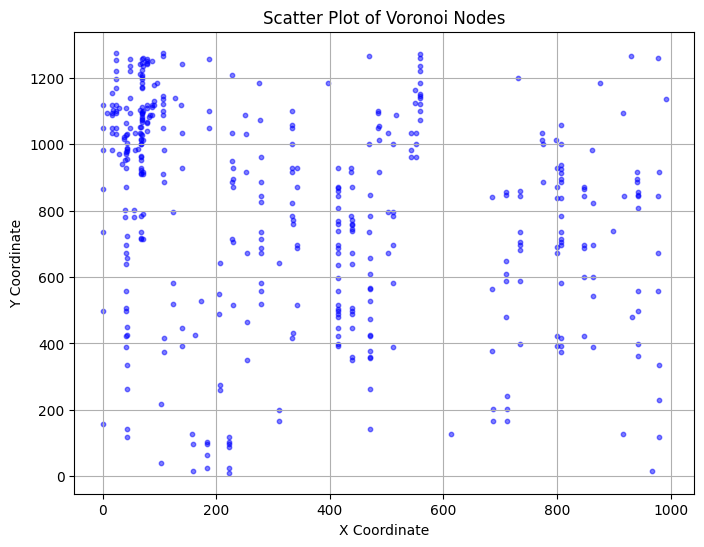

In [22]:
# Assuming voronoi_nodes contains the list of (a, x, y) tuples

# Extract x and y coordinates from the list of nodes
x_coords = [node[1] for node in voronoi_nodes]
y_coords = [node[2] for node in voronoi_nodes]

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, s=10, c='blue', marker='o', alpha=0.5)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of Voronoi Nodes')
plt.grid(True)
plt.show()

In [57]:
import numpy as np
from sklearn.cluster import KMeans

# Assuming voronoi_nodes contains the list of (a, x, y) tuples

# Convert the list of nodes to a numpy array
nodes_array = np.array(voronoi_nodes)

# Perform K-means clustering with k-means++ initialization
kmeans_pp = KMeans(n_clusters=12, init='k-means++', random_state=42)
kmeans_pp.fit(nodes_array)
indexes_pp = kmeans_pp.labels_

# Perform K-means clustering with random initialization
kmeans_random = KMeans(n_clusters=12, init='random', random_state=42)
kmeans_random.fit(nodes_array)
indexes_random = kmeans_random.labels_

# Store the results
results = {'kmeans_pp': indexes_pp, 'kmeans_random': indexes_random}

# Optionally, you can also store the cluster centers if needed
cluster_centers_pp = kmeans_pp.cluster_centers_
cluster_centers_random = kmeans_random.cluster_centers_

# Access the results as needed, e.g., results['kmeans_pp'], results['kmeans_random']


In [67]:
type(indexes_random)

numpy.ndarray

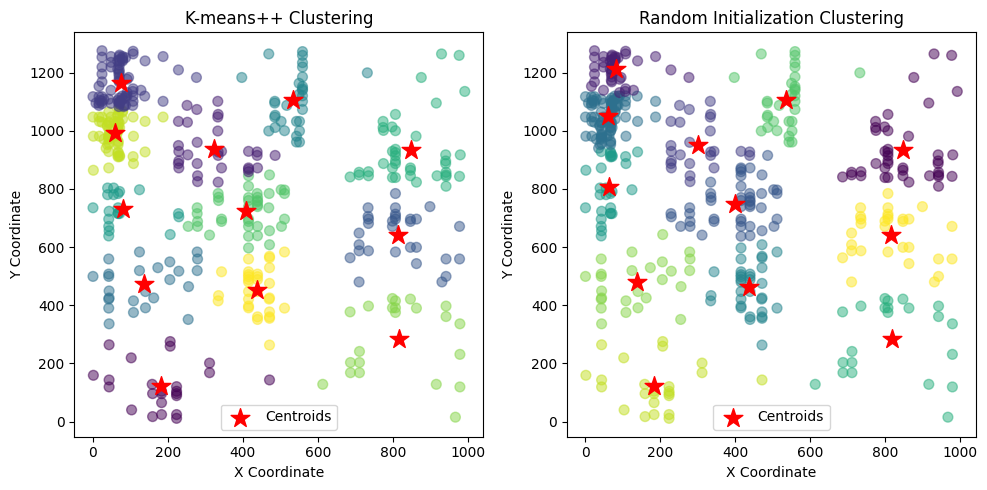

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Convert voronoi_nodes to a numpy array
voronoi_nodes_array = np.array(voronoi_nodes)

# Plot the clusters for k-means++ initialization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(voronoi_nodes_array[:, 1], voronoi_nodes_array[:, 2], c=results['kmeans_pp'], cmap='viridis', s=50, alpha=0.5)
plt.scatter(cluster_centers_pp[:, 1], cluster_centers_pp[:, 2], s=200, c='red', marker='*', label='Centroids')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('K-means++ Clustering')
plt.legend()

# Plot the clusters for random initialization
plt.subplot(1, 2, 2)
plt.scatter(voronoi_nodes_array[:, 1], voronoi_nodes_array[:, 2], c=results['kmeans_random'], cmap='viridis', s=50, alpha=0.5)
plt.scatter(cluster_centers_random[:, 1], cluster_centers_random[:, 2], s=200, c='red', marker='*', label='Centroids')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Random Initialization Clustering')
plt.legend()

plt.tight_layout()
plt.show()


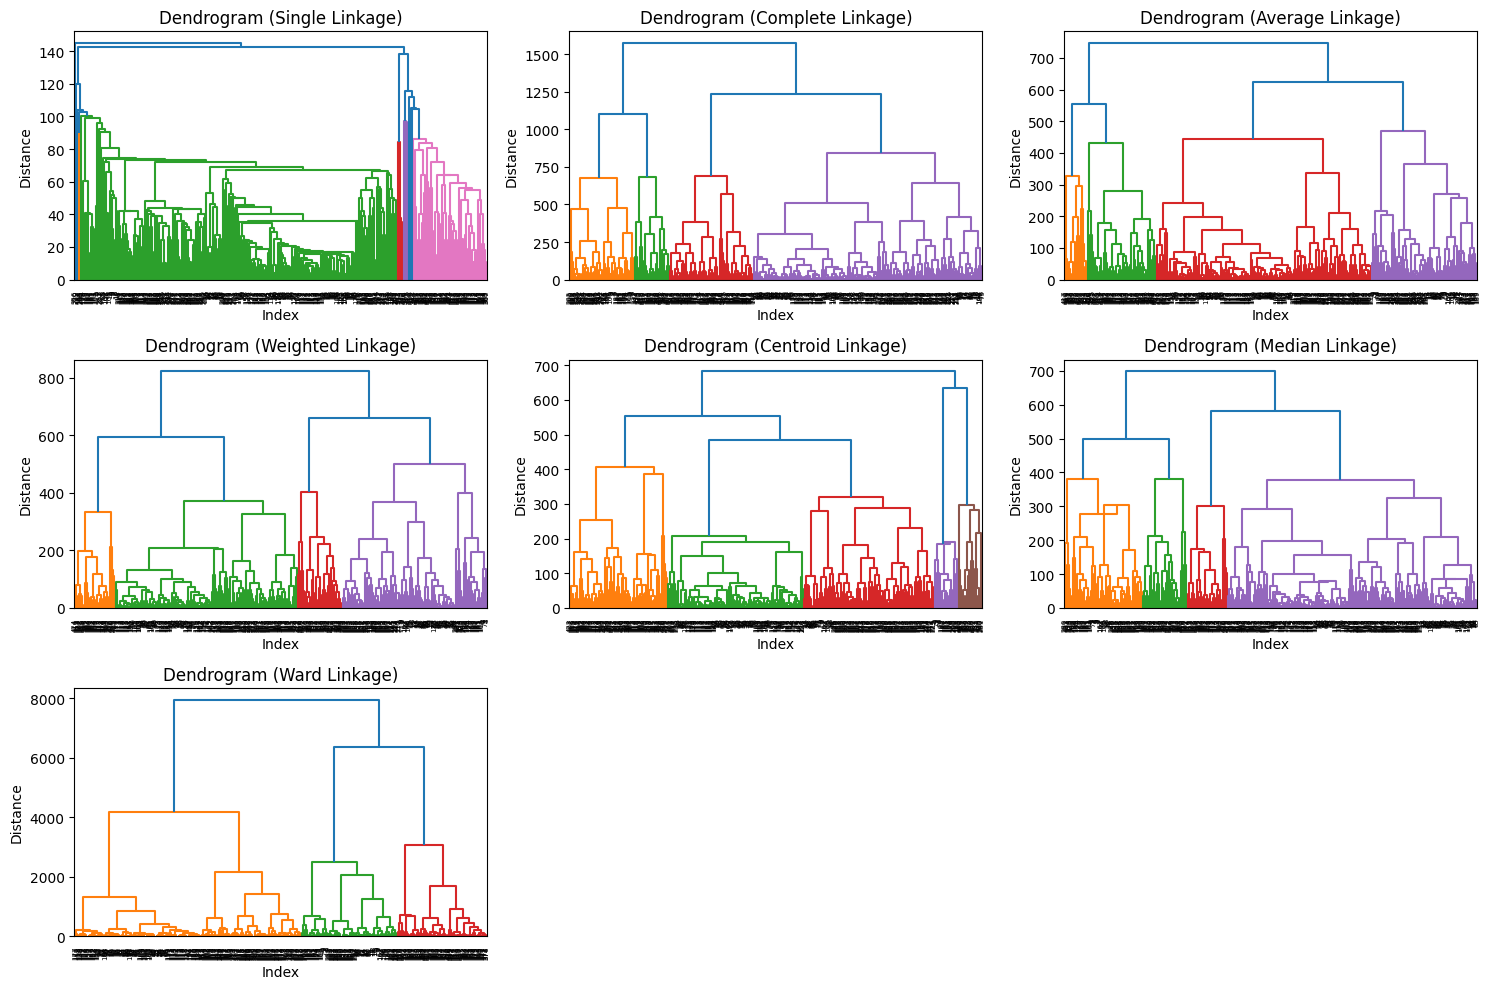

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

# Assuming voronoi_nodes contains the list of (a, x, y) tuples

# Convert the list of nodes to a numpy array
nodes_array = np.array(voronoi_nodes)

# Define the linkage methods to use
linkage_methods = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']

# Plot dendrograms and store labels for each linkage method
plt.figure(figsize=(15, 10))
for i, method in enumerate(linkage_methods, 1):
    plt.subplot(3, 3, i)
    Z = linkage(nodes_array, method=method)
    dendrogram(Z)
    plt.title(f'Dendrogram ({method.capitalize()} Linkage)')
    plt.xlabel('Index')
    plt.ylabel('Distance')
    
    # Perform clustering using the current linkage method and store labels
    labels = f"{method}_labels"
    globals()[labels] = cut_tree(Z, n_clusters=3).flatten()

plt.tight_layout()
plt.show()

# Now you have separate variables for labels obtained from each linkage method


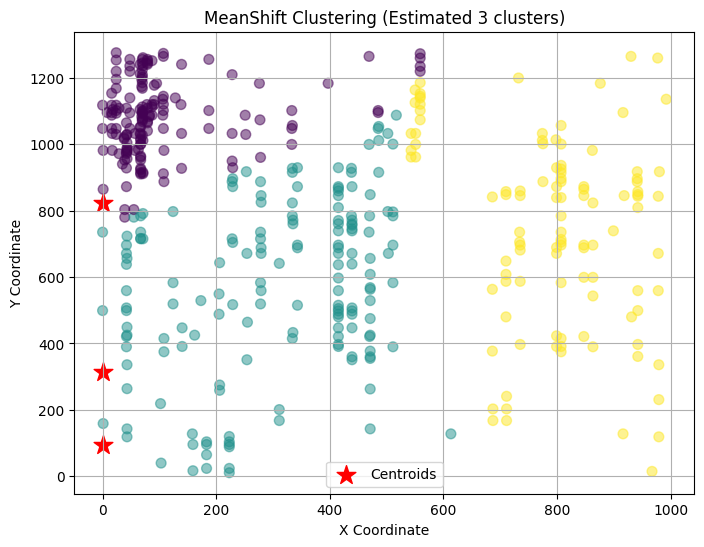

In [89]:

from sklearn.cluster import MeanShift, estimate_bandwidth

# Assuming voronoi_nodes contains the list of (a, x, y) tuples

# Convert the list of nodes to a numpy array
nodes_array = np.array(voronoi_nodes)

# Estimate bandwidth
bandwidth = estimate_bandwidth(nodes_array, quantile=0.2, n_samples=500)

# Perform MeanShift clustering
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(nodes_array)
mslabels = ms.labels_
cluster_centers = ms.cluster_centers_

# Number of clusters
n_clusters_ = len(np.unique(mslabels))

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(nodes_array[:, 1], nodes_array[:, 2], c=labels, cmap='viridis', s=50, alpha=0.5)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=200, c='red', marker='*', label='Centroids')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f'MeanShift Clustering (Estimated {n_clusters_} clusters)')
plt.legend()
plt.grid(True)
plt.show()


In [96]:
# Combine the labels into a single matrix
all_labels = np.column_stack((indexes_pp, indexes_random, single_labels, complete_labels, average_labels, weighted_labels, centroid_labels, median_labels, ward_labels, mslabels,voronoi_nodes_array[:, 1], voronoi_nodes_array[:, 2]))

# Check the shape of the resulting matrix
print("Shape of the combined labels matrix:", all_labels.shape, type(all_labels))

Shape of the combined labels matrix: (427, 12) <class 'numpy.ndarray'>


In [105]:
import numpy as np

# Assuming all_labels contains the combined labels matrix

# Transpose the matrix so that each row represents the labels assigned by a single clustering method for all nodes
all_labels_transposed = all_labels.T

# Find nodes that were labeled similarly across all methods
similarly_labeled_indices = np.where((all_labels_transposed[0] == all_labels_transposed[1]) & 
                                     (all_labels_transposed[1] == all_labels_transposed[2]) &
                                     (all_labels_transposed[2] == all_labels_transposed[3]) &
                                     (all_labels_transposed[3] == all_labels_transposed[4]) &
                                     (all_labels_transposed[4] == all_labels_transposed[5]) &
                                     (all_labels_transposed[5] == all_labels_transposed[6]) &
                                     (all_labels_transposed[6] == all_labels_transposed[7]) &
                                     (all_labels_transposed[7] == all_labels_transposed[8]) &
                                     (all_labels_transposed[8] == all_labels_transposed[9]) &
                                     (all_labels_transposed[9] == all_labels_transposed[10]))[0]

# Get the corresponding nodes with their labels and coordinates
similarly_labeled_nodes = all_labels[similarly_labeled_indices]

# Display the similarly labeled nodes
print("Similarly labeled nodes:")
print(similarly_labeled_nodes)


Similarly labeled nodes:
[]


In [107]:
all_labels_transposed

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 7.000e+00, 7.000e+00,
        7.000e+00],
       [1.000e+01, 1.000e+01, 1.000e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 1.000e+00,
        1.000e+00],
       ...,
       [1.000e+00, 1.000e+00, 1.000e+00, ..., 2.000e+00, 2.000e+00,
        2.000e+00],
       [4.300e+01, 1.000e+00, 4.300e+01, ..., 9.800e+02, 9.920e+02,
        9.770e+02],
       [1.190e+02, 1.590e+02, 1.430e+02, ..., 9.170e+02, 1.135e+03,
        1.259e+03]])

## Elbow Method

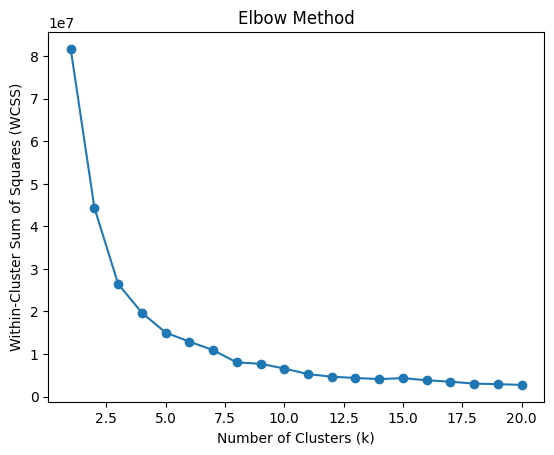

In [51]:

# Assuming voronoi_nodes contains the list of (a, x, y) tuples

# Convert the list of nodes to a numpy array
nodes_array = np.array(voronoi_nodes)

# Calculate within-cluster sum of squares for different values of k
wcss = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(nodes_array)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 21), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method')
plt.show()


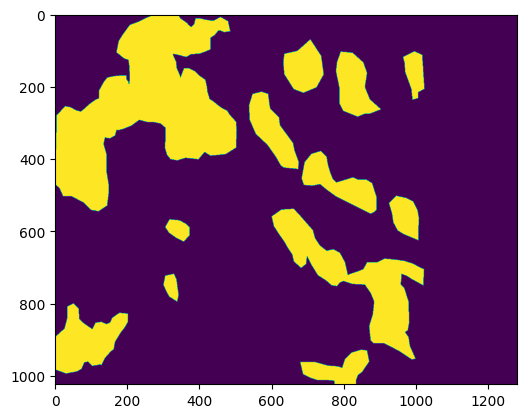

In [40]:
annotate=np.load('../Assets/030907c-20x-roi2.xml.npy')
plt.imshow(annotate)

In [39]:
values.shape

(427, 1)